In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from src.train_pm import Dataset, double_conv, LeUNet, StandardNet, EnsembleNet, EPAPLN, ResNetUNet, EnsembleLeUNet
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from src.preprocessing.trans_func import *
import torchvision.models as models

In [61]:
# !pip install opencv-python

In [2]:
data = pd.read_csv('../test_data.csv')
files = list(data['filename'])
ppm = list(data['ppm'])
ids = [i for i in range(len(files))]

In [206]:
# model = LeUNet()
# model = torch.nn.DataParallel(model).cuda()
# model.load_state_dict(torch.load("../src/model_pm_train.pth"),strict=False) # on GPU

<All keys matched successfully>

In [4]:
# model = ResNetUNet()
# model = torch.nn.DataParallel(model).cuda()
# model.load_state_dict(torch.load("../src/resnetunet_pm_train.pth"),strict=False) # on GPU

In [242]:
# model = StandardNet('resnet50').cuda()
# model.load_state_dict(torch.load("../src/resnet50_pm_train.pth"),strict=False)

<All keys matched successfully>

In [278]:
# model = StandardNet('vgg16').cuda()
# model.load_state_dict(torch.load("../src/vgg16_pm_train.pth"),strict=False)

<All keys matched successfully>

In [32]:
model = StandardNet('inception_v3').cuda()
model.load_state_dict(torch.load("../src/inception_cctv.pth"),strict=False)

<All keys matched successfully>

In [314]:
# model = EPAPLN().cuda()
# model.load_state_dict(torch.load("../src/epapln_pm_train.pth"),strict=False)

<All keys matched successfully>

In [58]:
# model = EnsembleNet().cuda()
# model.load_state_dict(torch.load("../src/ensemble_pm_train.pth"),strict=False)

/scratch/ab9738/chest/env_chest/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


<All keys matched successfully>

In [170]:
# model = EnsembleLeUNet().cuda()
# model.load_state_dict(torch.load("../src/ensembleleunet_pm_train.pth"),strict=False)

/scratch/ab9738/chest/env_chest/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


<All keys matched successfully>

In [4]:
dataset = Dataset(ids, files, ppm, transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize(mean=[0.5231, 0.5180, 0.5115],std=[0.2014, 0.2018, 0.2100]),])) # normalize
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=12)

In [33]:
model = model.eval()

In [34]:
actual = []
preds = []
for x, y in loader:
    y = y.float()
    x = x.cuda(non_blocking=True)
    y = y.cuda(non_blocking=True)

    x_var = torch.autograd.Variable(x)
    y_var = torch.autograd.Variable(y)

    yhat = model(x_var).squeeze()
    actual += [y_var.cpu().detach().numpy()]
    preds += [yhat.cpu().detach().numpy()]

In [35]:
actual = np.concatenate(actual)

In [36]:
preds = np.concatenate(preds)

## Basic Stats

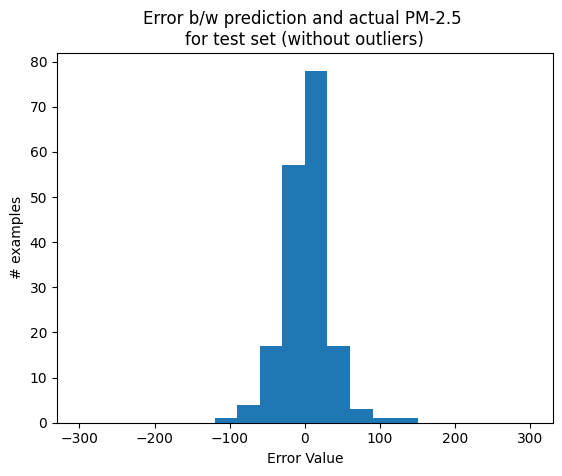

2.4124413
30.782879


In [94]:
err_test = np.array(preds)-np.array(actual)
plt.hist(err_test, bins=20,range=(-300,300))
plt.title("Error b/w prediction and actual PM-2.5 \nfor test set (without outliers)")
plt.xlabel('Error Value')
plt.ylabel('# examples')
plt.savefig('err_full.png')
plt.show()
print(np.mean(err_test))
print(np.std(err_test))

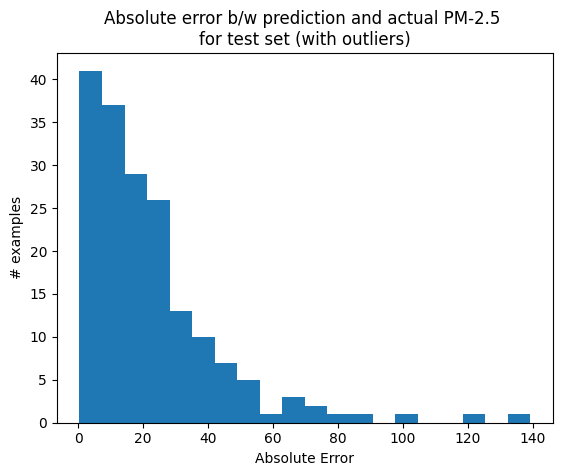

22.102623
21.561068


In [93]:
plt.hist(np.abs(err_test), bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor test set (with outliers)")
plt.xlabel('Absolute Error')
plt.ylabel('# examples')
plt.savefig('err_val.png')
plt.show()
print(np.mean(np.abs(err_test)))
print(np.std(np.abs(err_test)))

In [96]:
correct_p = 0
for i in range(len(preds)):
    if(abs(preds[i]-actual[i])<25):
        correct_p+=1
print(correct_p, len(preds), correct_p*1.0/len(preds))

126 179 0.7039106145251397


## Relative Rank Analysis

In [54]:
relative_rank_score = []
th_value = []
for th in range(5,151,5):
    num_pairs = 0
    num_correct = 0
    for i in range(len(actual)):
        for j in range(i+1, len(actual)):
            if(abs(actual[i]-actual[j])>th):
                num_pairs += 1
                if((preds[i]-preds[j])*(actual[i]-actual[j])>0):
                    num_correct += 1
                
    print(num_correct, num_pairs, num_correct/(num_pairs*1.0), th)
    relative_rank_score.append(num_correct/(num_pairs*1.0))
    th_value.append(th)

11925 14747 0.8086390452295382 5
11315 13689 0.8265760829863394 10
10727 12764 0.8404105296145409 15
10061 11719 0.8585203515658333 20
9305 10662 0.8727255674357531 25
8666 9789 0.8852793952395546 30
7978 8893 0.8971100865849545 35
7271 8056 0.9025571002979146 40
6576 7224 0.9102990033222591 45
5867 6385 0.9188723570869225 50
5263 5688 0.9252812939521801 55
4729 5077 0.9314555840063029 60
4144 4425 0.936497175141243 65
3670 3892 0.9429599177800617 70
3198 3370 0.9489614243323442 75
2804 2948 0.9511533242876526 80
2428 2547 0.9532783667059286 85
2050 2123 0.9656146961846443 90
1732 1792 0.9665178571428571 95
1484 1530 0.9699346405228758 100
1277 1309 0.975553857906799 105
1054 1071 0.9841269841269841 110
892 906 0.9845474613686535 115
763 772 0.9883419689119171 120
677 684 0.9897660818713451 125
577 584 0.988013698630137 130
495 502 0.9860557768924303 135
427 432 0.9884259259259259 140
365 370 0.9864864864864865 145
309 313 0.987220447284345 150


Text(0, 0.5, 'Probability of correct relative ranking')

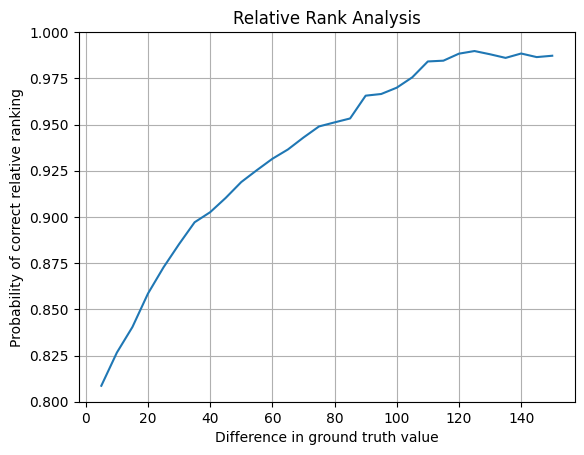

In [60]:
plt.plot(th_value,relative_rank_score)
plt.ylim([0.8,1])
plt.grid()
plt.title("Relative Rank Analysis")
plt.xlabel("Difference in ground truth value")
plt.ylabel("Probability of correct relative ranking")

## Tracking across time

In [73]:
files

['DITE, Okhla Industrial Area_523324_chan01_20220419_150140',
 'DITE, Okhla Industrial Area_523324_chan01_20220419_160140',
 'DITE, Okhla Industrial Area_523324_chan01_20220419_190140',
 'DITE, Okhla Industrial Area_523324_chan01_20220419_220141',
 'DITE, Okhla Industrial Area_523324_chan02_20220419_210145',
 'DITE, Okhla Industrial Area_523324_chan03_20220419_150145',
 'DITE, Okhla Industrial Area_523324_chan03_20220419_200149',
 'DITE, Okhla Industrial Area_523324_chan01_20220420_000140',
 'DITE, Okhla Industrial Area_523324_chan01_20220420_010141',
 'DITE, Okhla Industrial Area_523324_chan01_20220420_020141',
 'DITE, Okhla Industrial Area_523324_chan01_20220420_080149',
 'DITE, Okhla Industrial Area_523324_chan02_20220420_000142',
 'DITE, Okhla Industrial Area_523324_chan02_20220420_010143',
 'DITE, Okhla Industrial Area_523324_chan02_20220420_030142',
 'DITE, Okhla Industrial Area_523324_chan02_20220420_040141',
 'DITE, Okhla Industrial Area_523324_chan02_20220420_100151',
 'DITE, 

In [89]:
files_by_location = ([x for x in files if 'Sonia' in x])

In [90]:
start_idx = files.index(files_by_location[0])
end_idx = files.index(files_by_location[-1])

Text(0.5, 1.0, 'Tracking Across Time: Sonia Vihar')

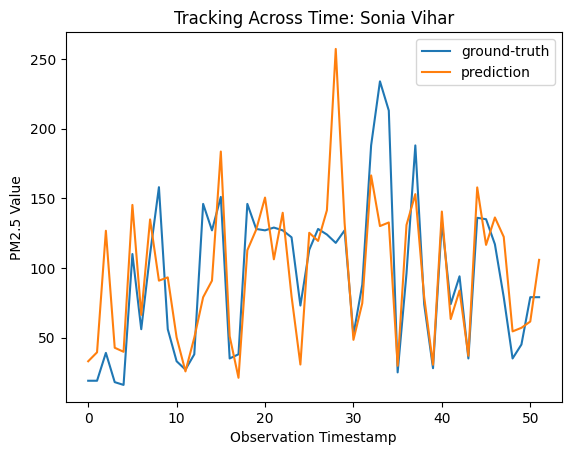

In [92]:
x = range(end_idx-start_idx+1)
plt.plot(x,actual[start_idx:end_idx+1], label='ground-truth')
plt.plot(x,preds[start_idx:end_idx+1], label='prediction')
plt.legend()
plt.ylabel("PM2.5 Value")
plt.xlabel("Observation Timestamp")
plt.title("Tracking Across Time: Sonia Vihar")